In [133]:
# 전제 : 시계열 데이터 처리
import pandas as pd
df = pd.read_csv("stock.csv")
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Volume    0
Close     0
dtype: int64

In [134]:
df.drop(["Date","Volume"], axis=1, inplace=True)

In [135]:
# stock : 
# 닫을 때 종가가 target이다 
# 주식을 며칠동안 볼건지 구간을 정해야 한다
# 한달이면 30일 
# 30일치 데이터를 가지고 내일 종가를 예측하겠다
# Open High Low 만 feature다 

In [136]:
# 딥러닝 RNN 으로 시계열 데이터 처리
# dataset, DataLoader import 하기
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# stockDataset 데이터셋 클래스 생성
# feature : Open, High, Low
# target : Close

class stockDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
    def __len__(self):
        return len(self.data) - self.window_size
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size, :-1]
        y = self.data[idx+self.window_size, -1]
        return x, y

In [137]:
trainDS = stockDataset(df.values, 30) # 한 달이라고 잡고, 데이터셋 생성 

In [138]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size): 
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, 1)
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1])
        out = self.fc2(out[:, -1])
        return out

In [139]:
# 데이터 로더 생성
trainDL = DataLoader(trainDS, batch_size=16, shuffle=True, drop_last=True)

In [140]:
# 학습 진행
model = RNN(3, 16)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())
x_map = []
y_map = []

for epoch in range(100):
    for i, (x, y) in enumerate(trainDL):
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        optimizer.zero_grad()
        output = model(x)
        print(x.shape, y.shape)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        x_map.append(output)
        y_map.append(y)
    print(epoch, loss.item())

C:\Users\mathn\AppData\Local\Temp\ipykernel_8564\2900822799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\mathn\AppData\Local\Temp\ipykernel_8564\2900822799.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
c:\ProgramData\anaconda3\envs\TEXT_017_220_38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Size([16, 1])
torch.Size([16, 30, 3]) torch.Si

In [141]:
output

tensor([227.7867], grad_fn=<AddBackward0>)

In [ ]:
flat_list = [item.item() for sublist in y_map for item in sublist]

averaged_list = []
for i in range(0, len(flat_list), 8):
    batch = flat_list[i:i+8]
    batch_mean = sum(batch) / len(batch)
    averaged_list.append(batch_mean)

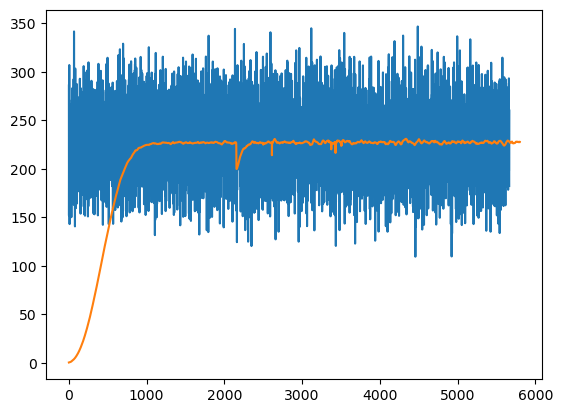

In [142]:
import matplotlib.pyplot as plt


plt.plot(averaged_list, label="real")
plt.plot(np.array(torch.tensor(x_map)), label="predict")
plt.show()
# 쫀드기 완성! 

In [ ]:
# 결론 : 중간이라도 가면 번다 (맞나?)